[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)

# Isotopic relaxation (e-folding) timescales comparison 
1. Comparison for different environment settings.
2. Equations for timescales from:
- [Bolin 1958 (Proc. 2nd UN Intl Conf. Peaceful Uses of Atomic Energy)](https://digitallibrary.un.org/record/3892725),
- [Gedzelman & Arnold 1994 (J. Geophys. Res. Atmos. 99)](https://doi.org/10.1029/93JD03518), 
- [Miyake et al. 1968 (Pap. Meteorol. Geophys. 19)](https://doi.org/10.2467/mripapers1950.19.2_243),
- [Jouzel et al. 1975 (J. Geophys. Res. 80)](https://doi.org/10.1029/JC080i036p05015) 


compared with derived formula from Fick's an Fourier laws.






In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.physics.constants import PER_CENT

In [3]:
any_non_zero_value = 44.0
radii_bolin = np.asarray([0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.20]) * si.cm
radii = np.linspace(0.005, 0.2) * si.cm
temperature = Formulae().constants.T0 + 10 * si.K
settings = {
    "terminal_velocity":"RogersYau",
    "particle_shape_and_density":"LiquidSpheres",
    "isotope_equilibrium_fractionation_factors":"VanHook1968",
    "isotope_diffusivity_ratios":"HellmannAndHarvey2020",
    "isotope_relaxation_timescale": "ZabaAndArabas2025",
}

In [4]:
formulae = Formulae(**settings)
const = formulae.constants
p = const.p_STP
D = formulae.diffusion_thermics.D(temperature, p)
K = formulae.diffusion_thermics.K(temperature, p)
lv = formulae.latent_heat_vapourisation.lv(temperature)
eta_air = formulae.air_dynamic_viscosity.eta_air(temperature)
air_density = p / const.Rd / temperature
v_term = formulae.terminal_velocity.v_term(radii)
Re = formulae.particle_shape_and_density.reynolds_number(
    radius=radii,
    velocity_wrt_air=v_term,
    dynamic_viscosity=eta_air,
    density=air_density,
)
Sc = formulae.trivia.air_schmidt_number(
    dynamic_viscosity=eta_air,
    diffusivity=D,
    density=air_density,
)
sqrt_re_times_cbrt_sc = formulae.trivia.sqrt_re_times_cbrt_sc(Re, Sc)
f = formulae.ventilation.ventilation_coefficient(sqrt_re_times_cbrt_sc)


In [5]:
adjustment_time = {
    "Bolin's table": np.asarray([3.3, 7.1, 33, 93, 165, 245, 365, 435]) * si.s,
}

In [6]:
isotopes = ('2H', '18O', '17O')
isotopes_attr = {
    'diff_iso': {isotope: getattr(formulae.isotope_diffusivity_ratios, f'ratio_{isotope}_heavy_to_light')(temperature) * D for isotope in isotopes},
    'alpha_l': {isotope: getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_l_{isotope}')(temperature) for isotope in isotopes},
    'R_liq': {isotope: getattr(const, f'VSMOW_R_{isotope}') for isotope in isotopes},
    'ventilation': {isotope: f for isotope in isotopes}
}
S = 0
R_vap = .00003
rho_s=const.rho_w
def timescale(isotope, S, R_vap):
    m_dm_dt = formulae.isotope_relaxation_timescale.isotope_m_dm_dt(
        rho_s=rho_s,
        radius=radii,
        D_iso=isotopes_attr['diff_iso'][isotope],
        D=D,
        S=S,
        R_liq=isotopes_attr['R_liq'][isotope],
        alpha=isotopes_attr['alpha_l'][isotope],
        R_vap=R_vap,
        Fk=formulae.drop_growth.Fk(temperature, K, lv)
    )
    return formulae.isotope_relaxation_timescale.tau(m_dm_dt)

## Comparison for different environment settings

In [28]:
plot_settings = {
    'xlabel': 'log radius [cm]',
    'ylabel': 'log $\\tau$ [s]',
    'yscale': 'log',
    'xscale': 'log',
}

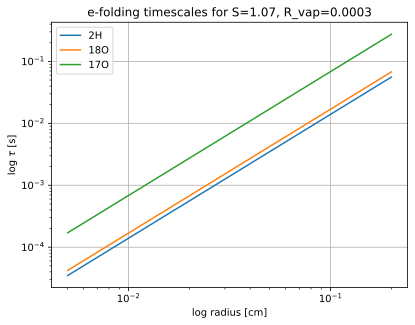

In [29]:
for isotope in isotopes:
    pyplot.plot(in_unit(radii, si.cm), timescale(
        isotope=isotope,
        S=S,
        R_vap=R_vap
    ), label=isotope)
pyplot.title(f'e-folding timescales for S={S}, R_vap={R_vap}')
pyplot.gca().set(**plot_settings)
pyplot.legend()
pyplot.grid()
show_plot('fig_isotopes')

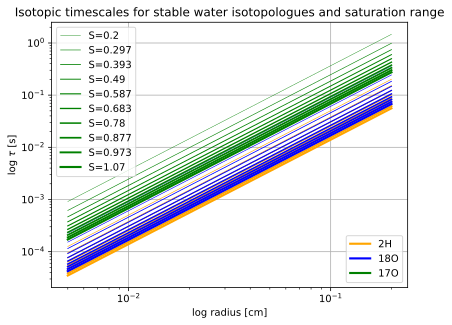

In [30]:
fig, ax = pyplot.subplots()
colors = ('orange', 'blue', 'green')
lines_S = []
S_range = np.linspace(0.2, 1.07, 10)
for S in S_range:
    lines_iso=[]
    for i, iso in enumerate(isotopes):
        line_iso, = ax.plot(in_unit(radii, si.cm), timescale(isotope=iso, S=S, R_vap=R_vap), color=colors[i], linewidth=2*S, label=iso)
        lines_iso.append(line_iso)
    legend = ax.legend(handles=lines_iso,  loc='lower right')
    lines_S.append(line_iso)
ax.add_artist(legend)
ax.legend(handles=lines_S, labels=[f'{S=:.3g}' for S in S_range])

ax.set_title('Isotopic timescales for stable water isotopologues and saturation range')
ax.set(**plot_settings)
ax.grid()
show_plot('fig_timescales_S')

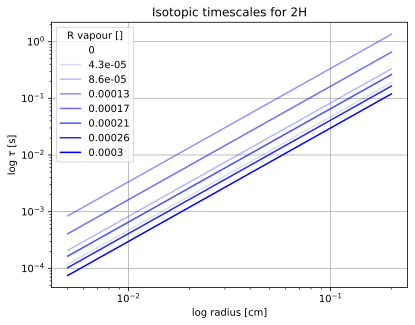

In [31]:
iso = '2H'
R_vap_range = np.linspace(0, 0.03, 8) * PER_CENT
for R_vap in R_vap_range:
    pyplot.plot(in_unit(radii, si.cm), timescale(isotope=iso, S=0.5, R_vap=R_vap), color='b', alpha=R_vap/R_vap_range[-1], label=f'{R_vap:.2g}')
pyplot.title(f'Isotopic timescales for {iso}')
pyplot.gca().set(**plot_settings)
pyplot.legend(title="R vapour []")
pyplot.grid()
show_plot('fig_timescales_R_vap')

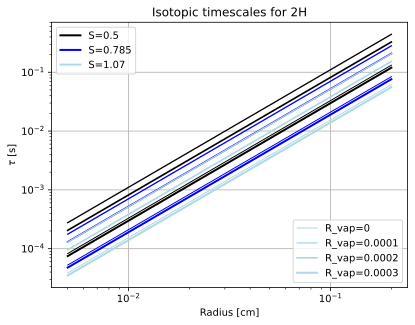

In [11]:
S_range = np.linspace(0.5, 1.07, 3)
R_vap_range = np.linspace(0, 0.03, 4) * PER_CENT
colors = ('k', 'blue', 'lightblue')
fig, ax = pyplot.subplots()
line_color=[]
for i, S in enumerate(S_range):
    lines = []
    for R_vap in R_vap_range:
        line, = ax.plot(in_unit(radii, si.cm), timescale(isotope=iso, S=S, R_vap=R_vap), linewidth=1+R_vap/R_vap_range[-1], color=colors[i], label=f'{R_vap=:.2g}')
        lines.append(line)
    legend = ax.legend(handles=lines,  loc='lower right')
    line_color.append(line)
ax.add_artist(legend)
ax.legend(handles=line_color, labels=[f'{S=:.3g}' for S in S_range])

pyplot.title(f'Isotopic timescales for {iso}')
pyplot.gca().set(**plot_settings)

pyplot.grid()
show_plot('fig_timescales_R_vap')
    

## Comparison of timescales equations from papers